In [5]:
import uproot 
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pylorentz import Momentum4
from pylorentz import Position4

In [6]:
# stop tensorflow trying to overfill GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [7]:
# loading the tree
tree = uproot.open("/eos/user/d/dwinterb/SWAN_projects/Masters_CP/MVAFILE_GluGluHToTauTauUncorrelatedDecay_Filtered_tt_2018.root")["ntuple"]
#tree2 = uproot.open("/eos/user/d/dwinterb/SWAN_projects/Masters_CP/MVAFILE_VBFHToTauTauUncorrelatedDecay_Filtered_tt_2018.root")["ntuple"]


#These are new trees, added by Danny on 13/10
#tree3=uproot.open("/eos/user/d/dwinterb/SWAN_projects/Masters_CP/MVAFILE_AllHiggs_tt.root")["ntuple"]  
#note, instead of the first t we can have e,m, different decay modes

In [12]:
# define what variables are to be read into the dataframe

features = [ "pi_E_1", "pi_px_1", "pi_py_1", "pi_pz_1", #leading charged pi 4-momentum
              "pi_E_2", "pi_px_2", "pi_py_2", "pi_pz_2", #subleading charged pi 4-momentum
              "pi0_E_1","pi0_px_1","pi0_py_1","pi0_pz_1", #leading neutral pi 4-momentum
              "pi0_E_2","pi0_px_2","pi0_py_2","pi0_pz_2", #subleading neutral pi 4-momentum
              "ip_x_1", "ip_y_1", "ip_z_1",        #leading impact parameter
              "ip_x_2", "ip_y_2", "ip_z_2",        #subleading impact parameter
              "y_1_1", "y_1_2"]    # ratios of energies

target =          ["aco_angle_1"]  #acoplanarity angle
    
selectors = [ "tau_decay_mode_1","tau_decay_mode_2",
             "mva_dm_1","mva_dm_2"
             ]

df = tree.pandas.df(features+target+selectors)

df = df[
      (df["tau_decay_mode_1"] == 1) 
    & (df["tau_decay_mode_2"] == 1) 
    & (df["mva_dm_1"] == 1) 
    & (df["mva_dm_2"] == 1)
]
#df2 = tree2.pandas.df(variables)

#tree3 should be more comprehensive and complete as it includes all decay types and more
#info for tau->a1 decays. Again we save the same variables for now

#df3 = tree3.pandas.df(variables)

#combine VBF and ggH events

#df = pd.concat([df,df2], ignore_index=True)

In [11]:
df.head()

,pi_E_1,pi_px_1,pi_py_1,pi_pz_1,pi_E_2,pi_px_2,pi_py_2,pi_pz_2,pi0_E_1,pi0_px_1,...,pi0_py_2,pi0_pz_2,ip_x_1,ip_y_1,ip_z_1,ip_x_2,ip_y_2,ip_z_2,y_1_1,y_1_2
entry,,,,,,,,,,,,,,,,,,,,,
4,26.184192,5.249920,-12.394966,-22.458754,52.305565,-10.016787,40.401790,-31.673523,95.932667,20.387663,...,4.944565,-4.242214,-0.000045,0.000480,-0.000170,-0.000894,0.000668,0.000903,0.571162,-0.773942
15,3.912128,3.186334,0.086207,-2.263873,32.211659,7.872188,29.660602,9.790244,64.282235,52.942869,...,14.794128,4.471416,0.006546,0.000134,0.009108,-0.002586,0.001020,-0.000611,0.885265,-0.339467
26,20.389432,12.846308,15.714182,1.935544,5.313678,-4.517069,-2.251007,1.656731,35.041365,21.823335,...,-17.362833,13.841466,0.002360,-0.000295,-0.011431,0.004199,0.003093,0.014879,0.264328,0.760691
39,4.532329,-1.060811,2.501133,-3.625128,11.348225,-2.284085,-6.326895,-9.138714,102.977036,-25.022726,...,-48.919660,-71.756611,-0.007268,-0.000030,0.002007,0.009565,-0.000590,-0.001876,0.915685,0.772376
55,77.929050,28.100279,42.522791,58.950012,72.891011,8.689332,15.745896,70.637400,68.260095,25.125369,...,51.238417,232.796864,-0.001563,0.000772,0.000324,-0.020295,0.027176,-0.004810,-0.066140,0.534360


In [24]:
# Create x and y
x = tf.convert_to_tensor(df[features], dtype="float32")
y = tf.convert_to_tensor(df[target], dtype="float32")

In [29]:
#define NN model and compile
model = tf.keras.models.Sequential([
    #tf.keras.layers.Flatten(),#input_shape=(24)),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

loss_fn = tf.keras.losses.MeanSquaredError()
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['mse'])

In [30]:
#train model
history = model.fit(x, y, validation_split=0.3, epochs=5)

Epoch 1/5
3183/3183 [==============================] - 5s 2ms/step - loss: 5.1249 - mse: 5.1249 - val_loss: 3.5407 - val_mse: 3.5407
Epoch 2/5
3183/3183 [==============================] - 5s 2ms/step - loss: 3.5225 - mse: 3.5225 - val_loss: 3.6208 - val_mse: 3.6208
Epoch 3/5
3183/3183 [==============================] - 5s 2ms/step - loss: 3.3799 - mse: 3.3799 - val_loss: 3.3416 - val_mse: 3.3416
Epoch 4/5
3183/3183 [==============================] - 5s 2ms/step - loss: 3.3342 - mse: 3.3342 - val_loss: 3.3095 - val_mse: 3.3095
Epoch 5/5
3183/3183 [==============================] - 5s 2ms/step - loss: 3.3191 - mse: 3.3191 - val_loss: 3.3036 - val_mse: 3.3036


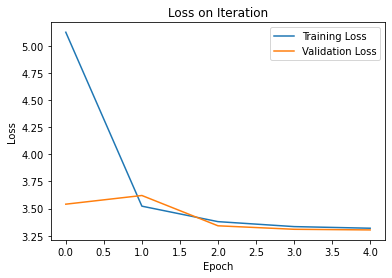

In [34]:
#plot traning
plt.figure()
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Loss on Iteration")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

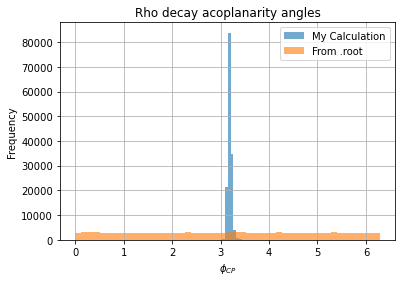

In [36]:
#Infer on full dataset
#TODO: only infer on validation set
Phi_CP = np.array(model(x))

#Plot the histogram
aco_angle_1 = np.array(df['aco_angle_1'])

plt.figure()
plt.title("Rho decay acoplanarity angles")
plt.hist(Phi_CP, label="My Calculation", alpha=0.625, bins=50)
plt.hist(aco_angle_1, label="From .root", alpha=0.625, bins=50)
plt.xlabel(r"$\phi_{CP}$")
plt.ylabel("Frequency")
plt.grid()
plt.legend()
plt.savefig("KingsleyTask1.png")
plt.show()
plt.close()

In [49]:
#print the first few results vs given angles
for i in range(10):
    print("{:.4f} \t {:.4f}".format(Phi_CP[i], aco_angle_1[i]))

5.9279 	 5.9279
5.0154 	 5.0154
0.1221 	 3.0195
0.4909 	 2.6507
3.0577 	 3.0577
4.0362 	 5.3886
4.3666 	 5.0581
3.4759 	 3.4759
3.7483 	 5.6765
4.7794 	 4.6454


In [53]:
(Phi_CP - aco_angle_1)[:10]

array([ 1.68753900e-14,  1.15463195e-14, -2.89747202e+00, -2.15976258e+00,
        1.88737914e-13, -1.35242812e+00, -6.91484309e-01, -5.77315973e-15,
       -1.92823855e+00,  1.34072471e-01])

In [55]:
residuals = (Phi_CP - aco_angle_1)
print("Incorrect {:.2f}% of the time".format(100*np.count_nonzero(np.round(residuals, 4))/len(residuals)))

Incorrect 48.82% of the time


In [56]:
#print first few residuals
for i in range(10):
    print("{:.4f}".format(residuals[i]))

0.0000
0.0000
-2.8975
-2.1598
0.0000
-1.3524
-0.6915
-0.0000
-1.9282
0.1341
